In [1]:
from lib.rdp.socket import RdpListener, RdpStream
from multiprocessing import Process
import matplotlib.pyplot as plt
from time import time_ns

In [2]:
START = 10_000
STOP = 10_000_000
STEP = START

HOST = "127.0.0.1"
PORT = 12000

WINSIZE = 10

# Start Listener

In [3]:
def receiver(listener: RdpListener):
    stream = listener.accept()
    for _ in range(START, STOP + 1, STEP):
        stream.recv(winsize=1)
        stream.recv(winsize=WINSIZE)
    listener.close()

listener = RdpListener.bind(HOST, PORT)
listener_proc = Process(target=receiver, args=(listener, ))
listener_proc.start()

# Execute client side

In [4]:
xs = []
ysw = []
ysr = []
data = bytearray()
stream = RdpStream.connect(HOST, PORT)
for size in range(START, STOP + 1, STEP):
    data.extend([0] * (size - len(data)))
    xs.append(size)

    # Stop & Wait
    now = time_ns()
    stream.send(data, winsize=1)
    ysw.append(time_ns() - now)

    # TCP + Selective ACK with WINSIZE
    now = time_ns()
    stream.send(data, winsize=WINSIZE)
    ysr.append(time_ns() - now)

stream.close()
listener_proc.join()

# Plot

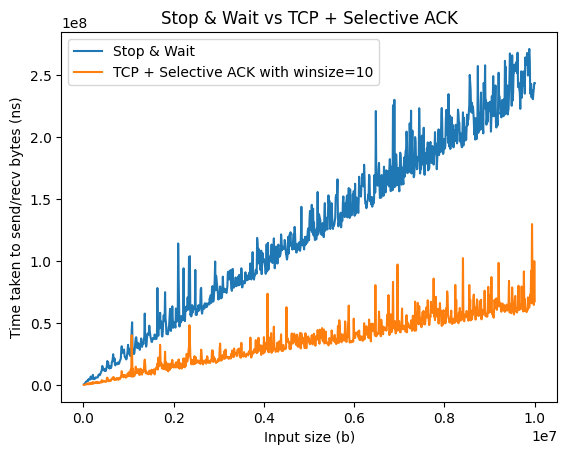

In [5]:
plt.title(f"Stop & Wait vs TCP + Selective ACK")
plt.xlabel("Input size (b)")
plt.ylabel("Time taken to send/recv bytes (ns)")
plt.plot(xs, ysw, label="Stop & Wait")
plt.plot(xs, ysr, label=f"TCP + Selective ACK with winsize={WINSIZE}")
plt.legend()
plt.show()